#### Artem Golotin
CS501R Lab 5

In [1]:
import tensorflow as tf

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Placeholders for data
I, O = 784, 10
x = tf.placeholder(tf.float32, shape=[None, I], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, O], name='output')
# Reshape the input image to match the first convolutional input dimentions
x_image = tf.reshape(x, [-1,28,28,1]) # 28 - width, 28 - height, 1 - color channels


### Convolutional and max pooling functions
conv2d = lambda x, W: tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
max_pool_2x2 = lambda x: tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### First convolutional layer
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))

# Convolve x_image with the weight tensor + bias, normalize the batch, apply ReLU and max pool
h_conv1 = conv2d(x_image, W_conv1) + b_conv1
h_mean1, h_var1 = tf.nn.moments(h_conv1, [0, 1, 2, 3])
h_norm1 = tf.nn.batch_normalization(h_conv1, h_mean1, h_var1, None, None, variance_epsilon=1e-3)
h_relu1 = tf.nn.relu(h_norm1)
h_pool1 = max_pool_2x2(h_relu1)

### Second convolutional layer
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

# Convolve x_image with the weight tensor + bias, normalize the batch, apply ReLU and max pool
h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
h_mean2, h_var2 = tf.nn.moments(h_conv2, [0, 1, 2, 3])
h_norm2 = tf.nn.batch_normalization(h_conv2, h_mean2, h_var2, None, None, variance_epsilon=1e-3)
h_relu2 = tf.nn.relu(h_norm2)
h_pool2 = max_pool_2x2(h_relu2)

### Fully connected layer
W_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
# Reshape the tensor from last pooling layer to a batch of vectors
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout layer to avoid overfitting and to calculate correct training accuracy
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer and final output
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
# Compute final output
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_pred), reduction_indices=[1]))
# Training function
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, epsilon=1e-4).minimize(cross_entropy)
# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
from tqdm import tqdm
import numpy as np

accuracies = []
# Run the session
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for epoch in tqdm(range(1001)):
        # Get next batch
        batch_x, batch_y = mnist.train.next_batch(100)
        grayscaled_x = np.apply_along_axis(np.subtract, 0, batch_x, np.average(batch_x, axis=1))
        train_x, train_y = np.vstack((batch_x, grayscaled_x)), np.vstack((batch_y, batch_y))
        # Train
        sess.run(train_step, feed_dict={x: train_x, y_: train_y, keep_prob: 0.5})
        # Get accuracy every 5 epochs (it's sooooo slow on CPU)
        if epoch % 5 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            accuracies.append(train_accuracy)
            print accuracies


  0%|          | 1/1001 [00:44<12:26:43, 44.80s/it]

[0.084200002]


  1%|          | 6/1001 [01:37<5:53:21, 21.31s/it]

[0.084200002, 0.2626]


  1%|          | 11/1001 [02:29<4:46:59, 17.39s/it]

[0.084200002, 0.2626, 0.36390001]


  2%|▏         | 16/1001 [03:20<4:28:09, 16.33s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998]


  2%|▏         | 21/1001 [04:11<4:23:33, 16.14s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002]


  3%|▎         | 26/1001 [05:02<4:20:28, 16.03s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997]


  3%|▎         | 31/1001 [05:52<4:19:24, 16.05s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003]


  4%|▎         | 36/1001 [06:43<4:18:55, 16.10s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999]


  4%|▍         | 41/1001 [07:35<4:19:56, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001]


  5%|▍         | 46/1001 [08:26<4:16:42, 16.13s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998]


  5%|▌         | 51/1001 [09:17<4:16:59, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161]


  6%|▌         | 56/1001 [10:10<4:22:03, 16.64s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998]


  6%|▌         | 61/1001 [11:02<4:18:37, 16.51s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001]


  7%|▋         | 66/1001 [11:54<4:16:20, 16.45s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998]


  7%|▋         | 71/1001 [12:46<4:16:42, 16.56s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998]


  8%|▊         | 76/1001 [13:39<4:18:16, 16.75s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531]


  8%|▊         | 81/1001 [14:32<4:17:18, 16.78s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664]


  9%|▊         | 86/1001 [15:26<4:21:51, 17.17s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682]


  9%|▉         | 91/1001 [16:23<4:31:48, 17.92s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999]


 10%|▉         | 96/1001 [17:15<4:12:19, 16.73s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002]


 10%|█         | 101/1001 [18:07<4:04:42, 16.31s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997]


 11%|█         | 106/1001 [18:58<4:01:53, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998]


 11%|█         | 111/1001 [19:51<4:04:55, 16.51s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001]


 12%|█▏        | 116/1001 [20:43<4:03:48, 16.53s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001]


 12%|█▏        | 121/1001 [21:36<4:04:26, 16.67s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999]


 13%|█▎        | 126/1001 [22:28<3:58:22, 16.35s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973]


 13%|█▎        | 131/1001 [23:19<3:57:00, 16.35s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999]


 14%|█▎        | 136/1001 [24:11<3:56:40, 16.42s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998]


 14%|█▍        | 141/1001 [25:04<3:58:02, 16.61s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903]


 15%|█▍        | 146/1001 [25:55<3:51:10, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998]


 15%|█▌        | 151/1001 [26:46<3:46:57, 16.02s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066]


 16%|█▌        | 156/1001 [27:36<3:44:12, 15.92s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998]


 16%|█▌        | 161/1001 [28:27<3:42:50, 15.92s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999]


 17%|█▋        | 166/1001 [29:16<3:39:13, 15.75s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998]


 17%|█▋        | 171/1001 [30:06<3:38:12, 15.77s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997]


 18%|█▊        | 176/1001 [30:56<3:36:22, 15.74s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002]


 18%|█▊        | 181/1001 [31:47<3:36:32, 15.84s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999]


 19%|█▊        | 186/1001 [32:37<3:35:41, 15.88s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998]


 19%|█▉        | 191/1001 [33:28<3:34:58, 15.92s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003]


 20%|█▉        | 196/1001 [34:18<3:31:43, 15.78s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999]


 20%|██        | 201/1001 [35:08<3:30:11, 15.76s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002]


 21%|██        | 206/1001 [35:58<3:28:39, 15.75s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999]


 21%|██        | 211/1001 [36:49<3:29:32, 15.91s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997]


 22%|██▏       | 216/1001 [37:39<3:26:30, 15.78s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998]


 22%|██▏       | 221/1001 [38:30<3:25:50, 15.83s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002]


 23%|██▎       | 226/1001 [39:20<3:23:55, 15.79s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003]


 23%|██▎       | 231/1001 [40:11<3:27:53, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998]


 24%|██▎       | 236/1001 [41:02<3:22:50, 15.91s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278]


 24%|██▍       | 241/1001 [41:52<3:20:25, 15.82s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001]


 25%|██▍       | 246/1001 [42:42<3:18:55, 15.81s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998]


 25%|██▌       | 251/1001 [43:33<3:16:42, 15.74s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001]


 26%|██▌       | 256/1001 [44:23<3:15:28, 15.74s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999]


 26%|██▌       | 261/1001 [45:13<3:14:20, 15.76s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002]


 27%|██▋       | 266/1001 [46:06<3:25:42, 16.79s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999]


 27%|██▋       | 271/1001 [46:56<3:12:53, 15.85s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002]


 28%|██▊       | 276/1001 [47:46<3:10:30, 15.77s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999]


 28%|██▊       | 281/1001 [48:36<3:08:32, 15.71s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998]


 29%|██▊       | 286/1001 [49:26<3:06:35, 15.66s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002]


 29%|██▉       | 291/1001 [50:15<3:05:13, 15.65s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002]


 30%|██▉       | 296/1001 [51:05<3:05:02, 15.75s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998]


 30%|███       | 301/1001 [51:56<3:04:21, 15.80s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002]


 31%|███       | 306/1001 [52:46<3:01:38, 15.68s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003]


 31%|███       | 311/1001 [53:35<2:59:32, 15.61s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002]


 32%|███▏      | 316/1001 [54:25<2:59:32, 15.73s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364]


 32%|███▏      | 321/1001 [55:16<3:01:20, 16.00s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999]


 33%|███▎      | 326/1001 [56:09<3:06:28, 16.57s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998]


 33%|███▎      | 331/1001 [57:00<2:59:32, 16.08s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001]


 34%|███▎      | 336/1001 [57:50<2:55:48, 15.86s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998]


 34%|███▍      | 341/1001 [58:40<2:53:40, 15.79s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002]


 35%|███▍      | 346/1001 [59:30<2:52:06, 15.77s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999]


 35%|███▌      | 351/1001 [1:00:20<2:50:12, 15.71s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001]


 36%|███▌      | 356/1001 [1:01:10<2:49:12, 15.74s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418]


 36%|███▌      | 361/1001 [1:02:00<2:48:21, 15.78s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997]


 37%|███▋      | 366/1001 [1:02:51<2:47:25, 15.82s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998]


 37%|███▋      | 371/1001 [1:03:41<2:45:51, 15.80s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997]


 38%|███▊      | 376/1001 [1:04:31<2:44:27, 15.79s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411]


 38%|███▊      | 381/1001 [1:05:21<2:43:23, 15.81s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425]


 39%|███▊      | 386/1001 [1:06:11<2:42:07, 15.82s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002]


 39%|███▉      | 391/1001 [1:07:02<2:41:27, 15.88s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997]


 40%|███▉      | 396/1001 [1:07:52<2:39:44, 15.84s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386]


 40%|████      | 401/1001 [1:08:42<2:38:10, 15.82s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999]


 41%|████      | 406/1001 [1:09:33<2:38:26, 15.98s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429]


 41%|████      | 411/1001 [1:10:24<2:36:10, 15.88s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001]


 42%|████▏     | 416/1001 [1:11:14<2:34:27, 15.84s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003]


 42%|████▏     | 421/1001 [1:12:05<2:34:22, 15.97s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436]


 43%|████▎     | 426/1001 [1:12:55<2:32:44, 15.94s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002]


 43%|████▎     | 431/1001 [1:13:46<2:31:16, 15.92s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002]


 44%|████▎     | 436/1001 [1:14:37<2:30:58, 16.03s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001]


 44%|████▍     | 441/1001 [1:15:28<2:29:47, 16.05s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461]

 45%|████▍     | 446/1001 [1:16:19<2:28:44, 16.08s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 45%|████▌     | 451/1001 [1:17:10<2:27:47, 16.12s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 46%|████▌     | 456/1001 [1:18:01<2:26:20, 16.11s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 46%|████▌     | 461/1001 [1:18:52<2:24:18, 16.03s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 47%|████▋     | 466/1001 [1:19:43<2:23:25, 16.08s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 47%|████▋     | 471/1001 [1:20:34<2:22:11, 16.10s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 48%|████▊     | 476/1001 [1:21:25<2:20:40, 16.08s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 48%|████▊     | 481/1001 [1:22:17<2:20:21, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 49%|████▊     | 486/1001 [1:23:08<2:18:19, 16.12s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 49%|████▉     | 491/1001 [1:23:59<2:16:36, 16.07s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 50%|████▉     | 496/1001 [1:24:50<2:15:25, 16.09s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 50%|█████     | 501/1001 [1:25:41<2:13:57, 16.08s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 51%|█████     | 506/1001 [1:26:32<2:12:46, 16.09s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 51%|█████     | 511/1001 [1:27:23<2:11:33, 16.11s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 52%|█████▏    | 516/1001 [1:28:15<2:11:29, 16.27s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 52%|█████▏    | 521/1001 [1:29:06<2:09:11, 16.15s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 53%|█████▎    | 526/1001 [1:29:58<2:08:51, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 53%|█████▎    | 531/1001 [1:30:49<2:07:45, 16.31s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 54%|█████▎    | 536/1001 [1:31:40<2:04:50, 16.11s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 54%|█████▍    | 541/1001 [1:32:32<2:03:38, 16.13s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 55%|█████▍    | 546/1001 [1:33:22<2:01:51, 16.07s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 55%|█████▌    | 551/1001 [1:34:15<2:04:39, 16.62s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 56%|█████▌    | 556/1001 [1:35:06<2:00:31, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 56%|█████▌    | 561/1001 [1:35:58<1:58:59, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 57%|█████▋    | 566/1001 [1:36:49<1:57:54, 16.26s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 57%|█████▋    | 571/1001 [1:37:40<1:56:10, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 58%|█████▊    | 576/1001 [1:38:32<1:54:37, 16.18s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 58%|█████▊    | 581/1001 [1:39:23<1:53:04, 16.15s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 59%|█████▊    | 586/1001 [1:40:14<1:51:59, 16.19s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 59%|█████▉    | 591/1001 [1:41:05<1:50:42, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 60%|█████▉    | 596/1001 [1:41:56<1:49:13, 16.18s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 60%|██████    | 601/1001 [1:42:47<1:48:08, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 61%|██████    | 606/1001 [1:43:39<1:46:56, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 61%|██████    | 611/1001 [1:44:30<1:45:19, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 62%|██████▏   | 616/1001 [1:45:21<1:43:44, 16.17s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 62%|██████▏   | 621/1001 [1:46:12<1:42:28, 16.18s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 63%|██████▎   | 626/1001 [1:47:04<1:41:36, 16.26s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 63%|██████▎   | 631/1001 [1:47:55<1:40:28, 16.29s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 64%|██████▎   | 636/1001 [1:48:47<1:38:51, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 64%|██████▍   | 641/1001 [1:49:38<1:37:01, 16.17s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 65%|██████▍   | 646/1001 [1:50:29<1:36:01, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 65%|██████▌   | 651/1001 [1:51:20<1:34:29, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 66%|██████▌   | 656/1001 [1:52:12<1:33:26, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 66%|██████▌   | 661/1001 [1:53:03<1:31:49, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 67%|██████▋   | 666/1001 [1:53:54<1:30:30, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 67%|██████▋   | 671/1001 [1:54:45<1:29:09, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 68%|██████▊   | 676/1001 [1:55:38<1:29:03, 16.44s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 68%|██████▊   | 681/1001 [1:56:32<1:29:02, 16.69s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 69%|██████▊   | 686/1001 [1:57:24<1:26:04, 16.40s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 69%|██████▉   | 691/1001 [1:58:15<1:24:02, 16.27s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 70%|██████▉   | 696/1001 [1:59:06<1:22:35, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 70%|███████   | 701/1001 [1:59:57<1:21:01, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 71%|███████   | 706/1001 [2:00:49<1:19:36, 16.19s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 71%|███████   | 711/1001 [2:01:40<1:18:21, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 72%|███████▏  | 716/1001 [2:02:31<1:17:11, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 72%|███████▏  | 721/1001 [2:03:23<1:15:43, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 73%|███████▎  | 726/1001 [2:04:14<1:14:22, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 73%|███████▎  | 731/1001 [2:05:05<1:13:07, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 74%|███████▎  | 736/1001 [2:05:57<1:12:00, 16.30s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 74%|███████▍  | 741/1001 [2:06:48<1:10:17, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 75%|███████▍  | 746/1001 [2:07:42<1:11:33, 16.84s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 75%|███████▌  | 751/1001 [2:08:33<1:08:00, 16.32s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 76%|███████▌  | 756/1001 [2:09:24<1:06:25, 16.27s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 76%|███████▌  | 761/1001 [2:10:15<1:04:51, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 77%|███████▋  | 766/1001 [2:11:07<1:03:36, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 77%|███████▋  | 771/1001 [2:11:58<1:02:25, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 78%|███████▊  | 776/1001 [2:12:50<1:00:54, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 78%|███████▊  | 781/1001 [2:13:41<59:21, 16.19s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 79%|███████▊  | 786/1001 [2:14:32<58:04, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 79%|███████▉  | 791/1001 [2:15:23<56:41, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 80%|███████▉  | 796/1001 [2:16:14<55:24, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 80%|████████  | 801/1001 [2:17:06<54:16, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 81%|████████  | 806/1001 [2:17:57<52:56, 16.29s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 81%|████████  | 811/1001 [2:18:49<51:22, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 82%|████████▏ | 816/1001 [2:19:40<50:06, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 82%|████████▏ | 821/1001 [2:20:31<48:38, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 83%|████████▎ | 826/1001 [2:21:22<47:13, 16.19s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 83%|████████▎ | 831/1001 [2:22:14<46:08, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 84%|████████▎ | 836/1001 [2:23:05<44:34, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 84%|████████▍ | 841/1001 [2:23:57<43:33, 16.33s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 85%|████████▍ | 846/1001 [2:24:49<42:18, 16.38s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 85%|████████▌ | 851/1001 [2:25:40<40:35, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 86%|████████▌ | 856/1001 [2:26:31<39:13, 16.23s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 86%|████████▌ | 861/1001 [2:27:23<37:59, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 87%|████████▋ | 866/1001 [2:28:14<36:37, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 87%|████████▋ | 871/1001 [2:29:06<35:18, 16.29s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 88%|████████▊ | 876/1001 [2:29:57<33:55, 16.29s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 88%|████████▊ | 881/1001 [2:30:48<32:26, 16.22s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 89%|████████▊ | 886/1001 [2:31:40<31:01, 16.18s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 89%|████████▉ | 891/1001 [2:32:31<29:51, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 90%|████████▉ | 896/1001 [2:33:22<28:25, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 90%|█████████ | 901/1001 [2:34:14<27:07, 16.27s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 91%|█████████ | 906/1001 [2:35:05<25:43, 16.24s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 91%|█████████ | 911/1001 [2:35:57<24:24, 16.27s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 92%|█████████▏| 916/1001 [2:36:48<23:04, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 92%|█████████▏| 921/1001 [2:37:40<21:52, 16.41s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 93%|█████████▎| 926/1001 [2:38:31<20:19, 16.26s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 93%|█████████▎| 931/1001 [2:39:23<18:57, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 94%|█████████▎| 936/1001 [2:40:14<17:33, 16.21s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 94%|█████████▍| 941/1001 [2:41:05<16:16, 16.28s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 95%|█████████▍| 946/1001 [2:41:57<14:57, 16.33s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 95%|█████████▌| 951/1001 [2:42:48<13:32, 16.25s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 96%|█████████▌| 956/1001 [2:43:40<12:13, 16.29s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 96%|█████████▌| 961/1001 [2:44:31<10:50, 16.26s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 97%|█████████▋| 966/1001 [2:45:23<09:31, 16.33s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 97%|█████████▋| 971/1001 [2:46:14<08:10, 16.37s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 98%|█████████▊| 976/1001 [2:47:06<06:48, 16.34s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 98%|█████████▊| 981/1001 [2:47:57<05:26, 16.34s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 99%|█████████▊| 986/1001 [2:48:49<04:03, 16.26s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

 99%|█████████▉| 991/1001 [2:49:40<02:43, 16.31s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

100%|█████████▉| 996/1001 [2:50:32<01:21, 16.30s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

100%|██████████| 1001/1001 [2:51:23<00:00, 16.20s/it]

[0.084200002, 0.2626, 0.36390001, 0.54839998, 0.63480002, 0.68949997, 0.72970003, 0.75929999, 0.78920001, 0.79729998, 0.8161, 0.81599998, 0.83270001, 0.83929998, 0.84719998, 0.8531, 0.8664, 0.8682, 0.86629999, 0.87150002, 0.88129997, 0.88779998, 0.88980001, 0.89050001, 0.89829999, 0.8973, 0.89289999, 0.89749998, 0.903, 0.90789998, 0.9066, 0.90109998, 0.90189999, 0.90789998, 0.91039997, 0.91030002, 0.91159999, 0.91329998, 0.91790003, 0.92199999, 0.92400002, 0.91729999, 0.92009997, 0.92369998, 0.92540002, 0.92580003, 0.92409998, 0.9278, 0.92930001, 0.92839998, 0.92640001, 0.92629999, 0.92900002, 0.93279999, 0.93400002, 0.93779999, 0.93449998, 0.93400002, 0.93580002, 0.93449998, 0.93330002, 0.93300003, 0.93580002, 0.9364, 0.93349999, 0.93699998, 0.93720001, 0.93699998, 0.93800002, 0.94069999, 0.94190001, 0.9418, 0.94019997, 0.94059998, 0.93839997, 0.9411, 0.9425, 0.94160002, 0.93949997, 0.9386, 0.94029999, 0.9429, 0.94400001, 0.94450003, 0.9436, 0.94300002, 0.94480002, 0.94510001, 0.9461,

In [4]:
import matplotlib.pyplot as plt

def plot_accuracy():
    x = range(0, 1001, 5)
    plt.axhline(y=0.9, color='r', ls='dashed', label='90% Cutoff')
    plt.plot(x, accuracies)
    plt.ylabel("Classification Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(loc='best')
    plt.show()


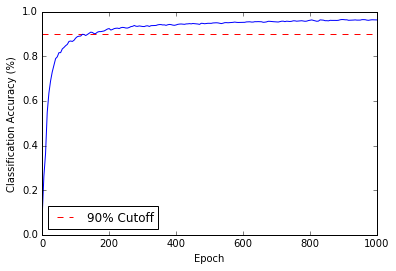

In [5]:
%matplotlib inline
plot_accuracy()